# Using Source and Sink Terms for a Chemical Reaction
`OpenPNM` is capable of simulating chemical reactions in pores by adding source and sink terms. This example shows how to add source and sink terms to a steady state fickian diffusion simulation.

In [1]:
import warnings
import scipy as sp
import numpy as np
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
np.set_printoptions(precision=5)
np.random.seed(10)
%matplotlib inline

## Create Network and Other Objects
Start by creating the network, geometry, phase and physics objects as usual:

In [2]:
pn = op.network.Cubic(shape=[40, 40], spacing=1e-4)
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)
gas = op.phases.Air(network=pn)
phys = op.physics.Standard(network=pn, phase=gas, geometry=geo)

Now add the source and sink models to the physics object.  In this case we'll think of the as chemical reactions.  We'll add one source term and one sink term, meaning one negative reaction rate and one positive reaction rate

In [3]:
gas['pore.concentration'] = 0
phys['pore.sinkA'] = -1e-10
phys['pore.sinkb'] = 1
phys.add_model(propname='pore.sink', model=op.models.physics.generic_source_term.power_law,
               A1='pore.sinkA', A2='pore.sinkb', X='pore.concentration')
phys['pore.srcA'] = 1e-11
phys['pore.srcb'] = 1
phys.add_model(propname='pore.source', model=op.models.physics.generic_source_term.power_law,
               A1='pore.srcA', A2='pore.srcb', X='pore.concentration')

## Setup Fickian Diffusion with Sink Terms
Now we setup a FickianDiffusion algorithm, with concentration boundary conditions on two side, and apply the sink term to 3 pores:

In [4]:
rx = op.algorithms.FickianDiffusion(network=pn)
rx.setup(phase=gas)
rx.set_source(propname='pore.sink', pores=[420, 820, 1220])
rx.set_value_BC(values=1, pores=pn.pores('front'))
rx.set_value_BC(values=1, pores=pn.pores('back'))
rx.run()

## Plot Distributions

We can use the ``plot_connections`` and ``plot_coordinates`` to get a quick view of the pore network, with colors and sizes scaled appropriately.

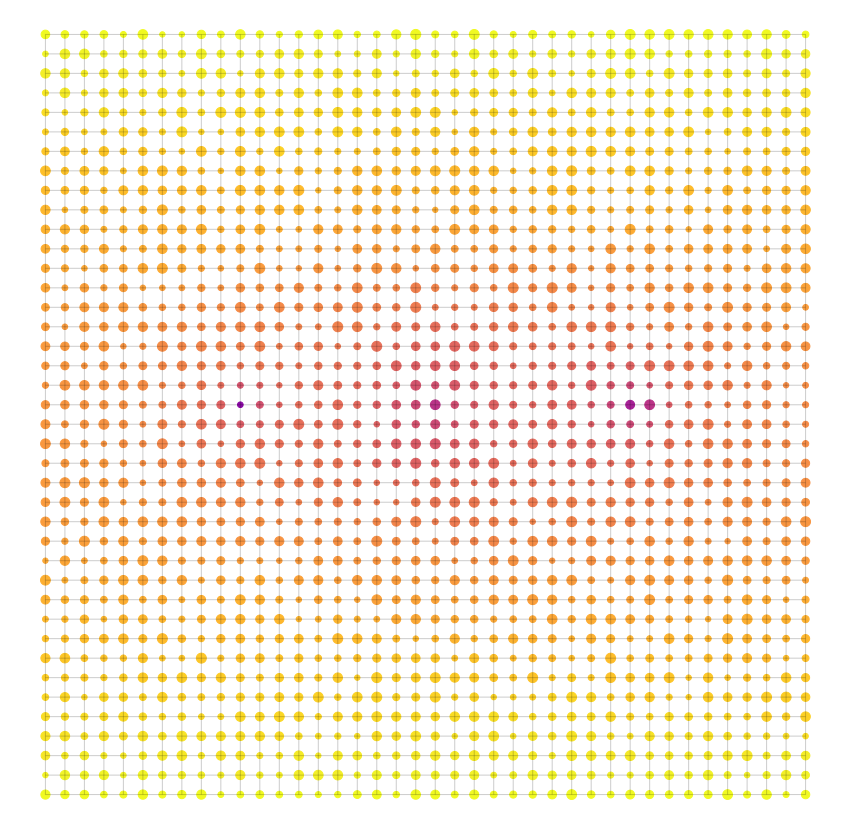

In [5]:
pn['pore.concentration'] = rx['pore.concentration']
fig, ax = plt.subplots(figsize=[15, 15])
op.topotools.plot_connections(network=pn, color='k', alpha=.2, ax=ax)
op.topotools.plot_coordinates(network=pn, color_by=pn['pore.concentration'],
                              size_by=pn['pore.diameter'], cmap='plasma',
                              ax=ax, markersize=100)
_ = plt.axis('off')

## Plot Distributions as Heatmaps
Because the network is a 2D cubic, it is convenient to visualize it as an image, so we reshape the 'pore.concentration' array that is produced by the FickianDiffusion algorithm upon running, and turn it into a colormap representing concentration in each pore.

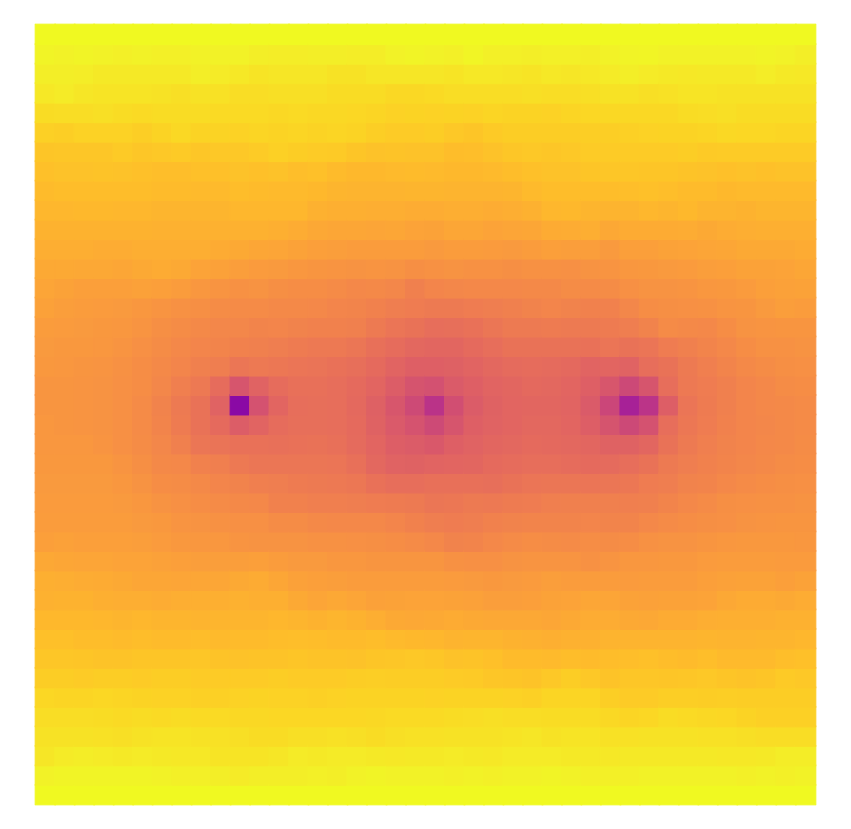

In [6]:
pn['pore.concentration'] = rx['pore.concentration']
fig, ax = plt.subplots(figsize=[15, 15])
op.topotools.plot_connections(network=pn, color='k', alpha=0, ax=ax)
op.topotools.plot_coordinates(network=pn, color_by=pn['pore.concentration'], cmap='plasma',
                              ax=ax, markersize=420, marker='s')
_ = plt.axis('off')

## Setup Fickian Diffusion with Source Terms
Similarly, for the source term:

In [7]:
rx = op.algorithms.FickianDiffusion(network=pn)
rx.setup(phase=gas)
rx.set_source(propname='pore.source', pores=[420, 820, 1220])
rx.set_value_BC(values=1, pores=pn.pores('front'))
rx.set_value_BC(values=1, pores=pn.pores('back'))
rx.run()

And plotting the result as a color map:

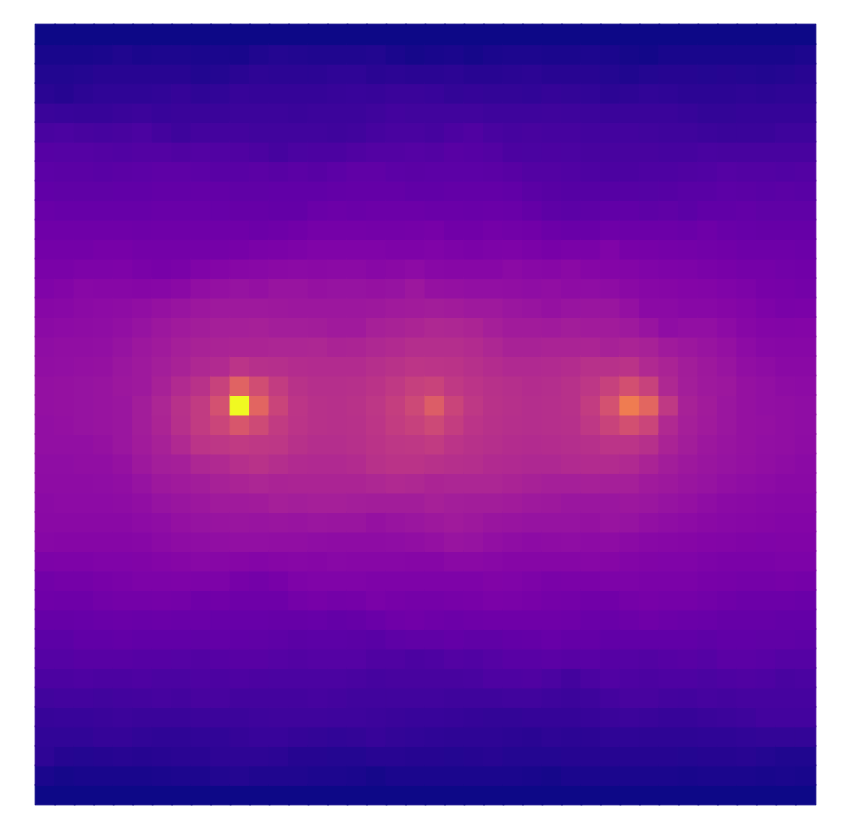

In [8]:
pn['pore.concentration'] = rx['pore.concentration'] - 1
fig, ax = plt.subplots(figsize=[15, 15])
op.topotools.plot_connections(network=pn, color='k', alpha=0, ax=ax)
op.topotools.plot_coordinates(network=pn, color_by=pn['pore.concentration'], cmap='plasma',
                              ax=ax, markersize=420, marker='s')
_ = plt.axis('off')